In [1]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('whitegrid')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Libertinus Sans', 'Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'

# Webis colours
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#90d7de',
    '#9ed977',
    '#ffab9e',
    '#d6acfa',
    '#ffc640',
    '#68b4c2',
    '#62ba61',
    '#ff6f52',
    '#bb86f3',
    '#e8a01d',
])

os.makedirs('../data/eval-figures', exist_ok=True)

In [3]:
# from collections import defaultdict
# import os
# import sys
# 
# import tira.rest_api_client
# from tqdm import tqdm
# 
# tira_client = tira.rest_api_client.Client(failsave_retries=1, failsave_max_delay=1)
# task = 'generative-ai-authorship-verification-panclef-2024'
# 
# task_datasets = [d for d in tira_client.datasets(task).keys()
#                  if d != 'pan24-generative-authorship-news-check-20240523-test' and not d.endswith('-training')]
# 
# evaluations = []
# for d in tqdm(task_datasets, desc='Retrieving evaluations'):
#     e = tira_client.evaluations(task, d)
#     if e.empty:
#         continue
#     evaluations.append(e[['dataset', 'team', 'software']])
# evaluations = pd.concat(evaluations).dropna().drop_duplicates()
# 
# teams_to_softwares = defaultdict(set)
# for _, r in evaluations.iterrows():
#     teams_to_softwares[r['team']].add(str(r['software']))
# with open('teams-to-systems.json', 'w') as f: json.dump({k: sorted(v) for k, v in teams_to_softwares.items()}, f, ensure_ascii=False, indent=2)
# 
# 
# # Block verbose output
# tira.rest_api_client.tqdm = lambda *args, **_: args
# tira.rest_api_client.print = lambda *args: None
# try:
#     evaluation_scores = defaultdict(lambda: defaultdict(dict))
#     for _, r in tqdm(evaluations.iterrows(), desc='Downloading runs'):
#         dir = tira_client.download_evaluation(task, r['dataset'], r['software'], r['team'])
#         if not os.path.isfile(os.path.join(dir, 'evaluation.json')):
#             print(f'Failed to download {r["team"]}/{r["software"]}/{r["dataset"]}', file=sys.stderr)
#             continue
#         with open(os.path.join(dir, 'evaluation.json')) as f:
#             evaluation_scores[r['team']][r['software']][r['dataset']] = json.load(f)
#             
#     with open('evaluation-scores.json', 'w') as f: json.dump(evaluation_scores, f, ensure_ascii=False, indent=2)
# finally:
#     # Unscrew output muffler
#     tira.rest_api_client.tqdm = tqdm
#     del tira.rest_api_client.print

In [4]:
teams_to_systems = json.load(open('teams-to-systems.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-topic', '', '-cross-topic'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240529-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

team_friendly_names = json.load(open('team-friendly-names.json'))
assert len(set(team_friendly_names.keys())) == len(set(team_friendly_names.values()))   # Friendly names must be unique

In [5]:
df_ = []
df_micro_mean_ = []

def _ensure_key_order(d):
    order = {
        'roc-auc': 0,
        'brier': 1,
        'c@1': 2,
        'f1': 3,
        'f05u': 4,
        'mean': 5,
    }
    return {k: v for k, v in sorted(d.items(), key=lambda x: order[x[0]])}
    
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        if team == 'baseline' and not s.startswith('baseline-'):
            continue
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        row_base['team'] = team_friendly_names.get(row_base['team'], row_base['team'])
        
        for d, (dname, pre, suff) in datasets.items():
            df_micro_mean_.append({
                **row_base,
                'category': dname,
                **_ensure_key_order({k:v for k, v in evaluation_scores[team].get(s, {}).get(d, {}).items() if k != '_sources'})
            })
            df_.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **_ensure_key_order(evaluation_scores[team][s][d]['_sources'][src])
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df_micro_mean_ = pd.DataFrame(df_micro_mean_)
df_micro_mean_.set_index(['team', 'system', 'category'], inplace=True)

df_ = pd.DataFrame(df_)

team_sys_ = df_[['team', 'system']].drop_duplicates()
src_ = df_[['category', 'dataset']].drop_duplicates()
df_.set_index(['team', 'system', 'category', 'dataset'], inplace=True)

# Fill missing values for fairness
fill_ = []
for _, ts in team_sys_.iterrows():
    if ts['team'].startswith('baseline-'):
        continue
    for _, s in src_.iterrows():
        idx = (ts['team'], ts['system'], s['category'], s['dataset'])
        if idx not in df_.index:
            f = {k: v for k, v in zip(df_.index.names, idx)}
            f.update({c: np.float64(None) for c in df_.columns})
            fill_.append(f)
if fill_:
    df_ = pd.concat([df_, pd.DataFrame.from_dict(fill_).set_index(df_.index.names)])

### Micro Mean (All)

In [6]:
df_micro_mean_

roc-auc  \
team                            system              category                
Baseline Binoculars (Falcon 7B) baseline-binoculars main            0.972   
                                                    cross-topic     0.970   
                                                    unicode-full    0.860   
                                                    unicode-half    0.298   
                                                    paraphrase      0.845   
...                                                                   ...   
ds-gtpan                        nervous-blur        unicode-half      NaN   
                                                    paraphrase        NaN   
                                                    contrastive     0.490   
                                                    short           0.494   
                                                    eloquent        0.727   

                                                                  brier  \
team                            system              category              
Baseline Binoculars (Falcon 7B) baseline-binoculars main          0.957   
                                                    cross-topic   0.955   
                                                    unicode-full  0.855   
                                                    unicode-half  0.462   
                                                    paraphrase    0.864   
...                                                                 ...   
ds-gtpan                        nervous-blur        unicode-half    NaN   
                                                    paraphrase      NaN   
                                                    contrastive   0.482   
                                                    short         0.482   
                                                    eloquent      0.725   

                                                                    c@1  \
team                            system              category              
Baseline Binoculars (Falcon 7B) baseline-binoculars main          0.966   
                                                    cross-topic   0.962   
                                                    unicode-full  0.837   
                                                    unicode-half  0.320   
                                                    paraphrase    0.841   
...                                                                 ...   
ds-gtpan                        nervous-blur        unicode-half    NaN   
                                                    paraphrase      NaN   
                                                    contrastive   0.482   
                                                    short         0.482   
                                                    eloquent      0.725   

                                                                     f1  \
team                            system              category              
Baseline Binoculars (Falcon 7B) baseline-binoculars main          0.964   
                                                    cross-topic   0.961   
                                                    unicode-full  0.831   
                                                    unicode-half  0.311   
                                                    paraphrase    0.840   
...                                                                 ...   
ds-gtpan                        nervous-blur        unicode-half    NaN   
                                                    paraphrase      NaN   
                                                    contrastive   0.547   
                                                    short         0.596   
                                                    eloquent      0.748   

                                                                   f05u   mean  
team                            system              cat

### Macro Mean (All)

In [7]:
df_

roc-auc  \
team                            system              category     dataset                                                
Baseline Binoculars (Falcon 7B) baseline-binoculars main         alpaca-7b                                      0.976   
                                                                 bigscience-bloomz-7b1                          0.993   
                                                                 gemini-pro                                     1.000   
                                                                 gemini-pro-high-temperature                    1.000   
                                                                 gpt-3.5-turbo-0125                             0.984   
...                                                                                                               ...   
ds-gtpan                        nervous-blur        unicode-half gpt-4-turbo-preview-unicode-half                 NaN   
                                                                 meta-llama-llama-2-70b-chat-hf-unicode-half      NaN   
                                                                 meta-llama-llama-2-7b-chat-hf-unicode-half       NaN   
                                                    paraphrase   gemini-pro-paraphrase-paraphrase                 NaN   
                                                                 gpt-4-turbo-preview-paraphrase-paraphrase        NaN   

                                                                                                              brier  \
team                            system              category     dataset                                              
Baseline Binoculars (Falcon 7B) baseline-binoculars main         alpaca-7b                                    0.967   
                                                                 bigscience-bloomz-7b1                        0.967   
                                                                 gemini-pro                                   0.983   
                                                                 gemini-pro-high-temperature                  0.980   
                                                                 gpt-3.5-turbo-0125                           0.963   
...                                                                                                             ...   
ds-gtpan                        nervous-blur        unicode-half gpt-4-turbo-preview-unicode-half               NaN   
                                                                 meta-llama-llama-2-70b-chat-hf-unicode-half    NaN   
                                                                 meta-llama-llama-2-7b-chat-hf-unicode-half     NaN   
                                                    paraphrase   gemini-pro-paraphrase-paraphrase               NaN   
                                                                 gpt-4-turbo-preview-paraphrase-paraphrase      NaN   

                                                                                                                c@1  \
team                            system              category     dataset                                              
Baseline Binoculars (Falcon 7B) baseline-binoculars main         alpaca-7b                                    0.979   
                                                                 bigscience-bloomz-7b1                        0.978   
                                                                 gemini-pro                                   1.000   
                                                                 gemini-pro-high-temperature                  0.996   
                                                                 gpt-3.5-turbo-0125                           0.974   
...                                                                                                             ...   
ds-gtpan                        nerv

### Final System Selection (by Best Micro Mean Effectiveness on Main Dataset Category)

In [8]:
df_systems_final = df_micro_mean_.query('category == "main"').groupby('team')['mean'].idxmax().dropna()
df_systems_final = df_micro_mean_.loc[df_systems_final].sort_values('mean', ascending=False)
df_systems_final = df_systems_final.reset_index()[['team', 'system']]
df_systems_final.set_index(['team', 'system'], inplace=True)
df_systems_final

,
team,system
Tavan,staff-trunk
Valdez-Valenzuela,final-run4-gnnllm_llmft_stylofeat-partitionB
J. Huang,charitable-mole_v3
Zi. Lin,blistering-moss
W. Huang,greasy-chest
Miralles,corporate-burn
Abburi,muffled-stock
L. Guo,merciless-lease
Lorenz,svm


### Dataframes Filtered

In [9]:
def _fill_nan_with_mean(df, idx_group_slice):
    """Fill NaN values with mean value of all systems."""
    df_mean = df.groupby(df.index.names[idx_group_slice]).mean().round(3)
    df_nan = df[df.isna().any(axis=1)]
    df = df.copy()
    for i, _ in df_nan.iterrows():
        df.loc[i] = df_mean.loc[i[idx_group_slice]]
    return df, df_nan.index

In [10]:
df = df_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df, df_nan = _fill_nan_with_mean(df, slice(-2, None))
df

roc-auc  brier    c@1  \
team  system      category dataset                                              
Tavan staff-trunk main     alpaca-7b                      1.000  0.995  0.995   
                           bigscience-bloomz-7b1          1.000  0.993  1.000   
                           gemini-pro                     1.000  0.999  1.000   
                           gemini-pro-high-temperature    1.000  0.997  0.996   
                           gpt-3.5-turbo-0125             1.000  0.997  1.000   
...                                                         ...    ...    ...   
G. Wu detector    eloquent eloquent-chatgpt35             0.821  0.781  0.688   
                           eloquent-gptsw3                0.539  0.615  0.458   
                           eloquent-reindeer-mistral      0.594  0.677  0.486   
                           eloquent-reindeer-poro         0.417  0.531  0.344   
                           eloquent-verbanex-ai           0.600  0.677  0.486   

                                                           f1   f05u   mean  
team  system      category dataset                                           
Tavan staff-trunk main     alpaca-7b                    0.995  0.998  0.996  
                           bigscience-bloomz-7b1        1.000  1.000  0.999  
                           gemini-pro                   1.000  1.000  1.000  
                           gemini-pro-high-temperature  0.997  0.999  0.998  
                           gpt-3.5-turbo-0125           1.000  1.000  0.999  
...                                                       ...    ...    ...  
G. Wu detector    eloquent eloquent-chatgpt35           0.762  0.656  0.742  
                           eloquent-gptsw3              0.286  0.349  0.449  
                           eloquent-reindeer-mistral    0.421  0.476  0.531  
                           eloquent-reindeer-poro       0.211  0.233  0.347  
                           eloquent-verbanex-ai         0.471  0.444  0.536  

[3010 rows x 6 columns]

In [11]:
print('Filled NaN values:')
df.loc[df_nan].reset_index()[['team', 'system', 'category', 'dataset']].drop_duplicates().set_index(['team', 'system', 'category', 'dataset'])

Filled NaN values:


Empty DataFrame
Columns: []
Index: [(Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, alpaca-7b-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, bigscience-bloomz-7b1-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-high-temperature-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-paraphrase-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-3.5-turbo-0125-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-german-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-paraphrase-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.1-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.6-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-70b-chat-hf-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-7b-chat-hf-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, mistralai-mistral-7b-instruct-v0.2-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, mistralai-mixtral-8x7b-instruct-v0.1-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, qwen-qwen1.5-72b-chat-8bit-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, text-bison-002-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, text-bison-002-german-short), (Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short, vicgalle-gpt2-open-instruct-v1-short), (B. Huang, bitter-metaphor, short, alpaca-7b-short), (B. Huang, bitter-metaphor, short, bigscience-bloomz-7b1-short), (B. Huang, bitter-metaphor, short, gemini-pro-short), (B. Huang, bitter-metaphor, short, gemini-pro-high-temperature-short), (B. Huang, bitter-metaphor, short, gemini-pro-paraphrase-short), (B. Huang, bitter-metaphor, short, gpt-3.5-turbo-0125-short), (B. Huang, bitter-metaphor, short, gpt-4-turbo-preview-short), (B. Huang, bitter-metaphor, short, gpt-4-turbo-preview-german-short), (B. Huang, bitter-metaphor, short, gpt-4-turbo-preview-paraphrase-short), (B. Huang, bitter-metaphor, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.1-short), (B. Huang, bitter-metaphor, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.6-short), (B. Huang, bitter-metaphor, short, meta-llama-llama-2-70b-chat-hf-short), (B. Huang, bitter-metaphor, short, meta-llama-llama-2-7b-chat-hf-short), (B. Huang, bitter-metaphor, short, mistralai-mistral-7b-instruct-v0.2-short), (B. Huang, bitter-metaphor, short, mistralai-mixtral-8x7b-instruct-v0.1-short), (B. Huang, bitter-metaphor, short, qwen-qwen1.5-72b-chat-8bit-short), (B. Huang, bitter-metaphor, short, text-bison-002-short), (B. Huang, bitter-metaphor, short, text-bison-002-german-short), (B. Huang, bitter-metaphor, short, vicgalle-gpt2-open-instruct-v1-short), (Qin, tender-couple, short, alpaca-7b-short), (Qin, tender-couple, short, bigscience-bloomz-7b1-short), (Qin, tender-couple, short, gemini-pro-short), (Qin, tender-couple, short, gemini-pro-high-temperature-short), (Qin, tender-couple, short, gemini-pro-paraphrase-short), (Qin, tender-couple, short, gpt-3.5-turbo-0125-short), (Qin, tender-couple, short, gpt-4-turbo-preview-short), (Qin, tender-couple, short, gpt-4-turbo-preview-german-short), (Qin, tender-couple, short, gpt-4-turbo-preview-paraphrase-short), (Qin, tender-couple, short, meta-llama-llama-2-13b-chat-hf-contrastive

In [12]:
df_micro_mean = df_micro_mean_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df_micro_mean, df_micro_mean_nan = _fill_nan_with_mean(df_micro_mean, slice(-1))
df_micro_mean

roc-auc  brier    c@1     f1   f05u   mean
team  system      category                                                
Tavan staff-trunk main            1.000  0.995  0.997  0.997  0.999  0.998
                  cross-topic     1.000  0.994  0.997  0.997  0.999  0.997
                  unicode-full    0.998  0.971  0.978  0.979  0.989  0.983
                  unicode-half    0.985  0.924  0.947  0.945  0.975  0.955
                  paraphrase      0.999  0.977  0.994  0.994  0.998  0.993
...                                 ...    ...    ...    ...    ...    ...
G. Wu detector    unicode-half    0.672  0.713  0.616  0.539  0.570  0.622
                  paraphrase      0.510  0.651  0.343  0.302  0.324  0.426
                  contrastive     0.533  0.598  0.491  0.433  0.441  0.499
                  short           0.629  0.700  0.531  0.491  0.506  0.571
                  eloquent        0.576  0.656  0.493  0.433  0.449  0.521

[344 rows x 6 columns]

In [13]:
print('Filled NaN values:')
df_micro_mean.loc[df_nan].reset_index()[['team', 'system', 'category']].drop_duplicates().set_index(['team', 'system', 'category'])

Filled NaN values:


Empty DataFrame
Columns: []
Index: [(Valdez-Valenzuela, final-run4-gnnllm_llmft_stylofeat-partitionB, short), (B. Huang, bitter-metaphor, short), (Qin, tender-couple, short), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, cross-topic), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, unicode-full), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, unicode-half), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, paraphrase), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, contrastive), (Baseline DetectLLM-LRR (Mistral 7B), baseline-detectllm-lrr-mistral, short), (Baseline DetectLLM-LRR (Falcon 7B), baseline-detectllm-lrr, contrastive)]

In [14]:
df_micro_mean_main_sorted = df_micro_mean.loc[:, :, 'main'].sort_values('mean', ascending=False)
df_micro_mean_main_sorted

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
Tavan,staff-trunk,1.000,0.995,0.997,0.997,0.999,0.998
Valdez-Valenzuela,final-run4-gnnllm_llmft_stylofeat-partitionB,0.992,0.992,0.992,0.992,0.991,0.992
J. Huang,charitable-mole_v3,0.991,0.991,0.991,0.990,0.989,0.990
Zi. Lin,blistering-moss,0.989,0.989,0.989,0.989,0.990,0.990
W. Huang,greasy-chest,0.979,0.979,0.979,0.979,0.979,0.979
Miralles,corporate-burn,0.995,0.954,0.976,0.976,0.976,0.976
Abburi,muffled-stock,0.987,0.967,0.970,0.970,0.970,0.973
L. Guo,merciless-lease,0.994,0.975,0.963,0.963,0.962,0.971
Lorenz,svm,0.994,0.923,0.976,0.976,0.975,0.969


### Submissions Statistics

In [15]:
global_stats = df_.reset_index()[~df_.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,31
system,102
dataset,70


### Teams to Notebook Paper IDs

In [16]:
submission_paper_map = json.load(open('teams-to-notebook.json'))
df_team_to_notebook = []
for t, s in submission_paper_map.items():
    if t == 'baseline':
        continue
    for sn, nb in s.items():
        df_team_to_notebook.append({'team': t, 'system': sn, 'notebook': nb})
df_team_to_notebook = pd.DataFrame(df_team_to_notebook)
df_team_to_notebook.set_index(['team', 'system'], inplace=True)
df_team_to_notebook.groupby('team').max().sort_values('notebook')

,notebook
team,
petropoulossiblings,82.0
aida,83.0
karami-kheiri,85.0
no-999,86.0
turtlewu,106.0
you-na-you-de,109.0
younanyousha,110.0
you-shun-you-de,115.0
verification-team,116.0


### System Effectiveness

In [17]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
print('System effectiveness (uncorrected):')
df_system_mean

System effectiveness (uncorrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
Tavan,staff-trunk,0.983786,0.958200,0.954529,0.942914,0.968886,0.961743
J. Huang,charitable-mole_v3,0.961186,0.956829,0.959000,0.943971,0.949029,0.954043
M. Guo,gritty-producer,0.954229,0.918914,0.948714,0.944843,0.945300,0.942300
Lorenz,svm,0.960286,0.894543,0.927429,0.924614,0.921300,0.925586
Zi. Lin,blistering-moss,0.911314,0.911114,0.911114,0.910757,0.910186,0.910871
Abburi,muffled-stock,0.920486,0.907500,0.895686,0.890243,0.887814,0.900400
Lv,proud-stick,0.916400,0.913814,0.894214,0.855057,0.867986,0.889443
Yadagiri,direct-velocity,0.927914,0.848843,0.900857,0.879357,0.881343,0.887629
Miralles,corporate-burn,0.895786,0.872957,0.868114,0.865200,0.861114,0.872614


In [18]:
df_system_std = df.groupby(['team', 'system']).std().sort_values('mean')
print('System effectiveness standard deviation:')
df_system_std

System effectiveness standard deviation:


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
gra,ash-causeway,0.000000,0.000000,0.056833,0.052673,0.056791,0.033293
J. Huang,charitable-mole_v3,0.061141,0.062368,0.062683,0.077989,0.071138,0.065424
e-comm-tech,great-plan,0.084094,0.042057,0.074928,0.091401,0.094418,0.072461
Tavan,staff-trunk,0.045342,0.060997,0.084438,0.118335,0.073872,0.075345
Lorenz,svm,0.069774,0.052038,0.090368,0.098450,0.104612,0.079974
Abburi,muffled-stock,0.109392,0.088874,0.122443,0.131184,0.135244,0.114998
M. Guo,gritty-producer,0.131218,0.087614,0.123905,0.122460,0.122986,0.115778
G. Wu,detector,0.128336,0.096455,0.135560,0.130567,0.128764,0.117414
Zi. Lin,blistering-moss,0.120349,0.121625,0.121625,0.117988,0.123368,0.120326


In [19]:
df_system_mean_adjusted = (df_system_mean - 0.5 * df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')

df_system_mean_adjusted.reset_index().to_latex(open('../data/eval-figures/system-effectiveness-adjusted.tex', 'w'), float_format='%.3f', index=False)
df_system_mean_adjusted.reset_index().to_html(open('../data/eval-figures/system-effectiveness-adjusted.html', 'w'), float_format='%.3f', index=False)

print('System effectiveness (corrected):')
df_system_mean_adjusted

System effectiveness (corrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
Tavan,staff-trunk,0.961115,0.927702,0.912309,0.883747,0.931950,0.924070
J. Huang,charitable-mole_v3,0.930615,0.925645,0.927658,0.904977,0.913460,0.921331
Lorenz,svm,0.925399,0.868524,0.882245,0.875389,0.868994,0.885599
M. Guo,gritty-producer,0.888620,0.875107,0.886762,0.883613,0.883807,0.884411
Zi. Lin,blistering-moss,0.851140,0.850302,0.850302,0.851763,0.848502,0.850708
Abburi,muffled-stock,0.865790,0.863063,0.834464,0.824651,0.820192,0.842901
Miralles,corporate-burn,0.830889,0.825426,0.794835,0.788064,0.782064,0.806248
Yadagiri,direct-velocity,0.844403,0.793164,0.805228,0.789444,0.791814,0.805787
Lv,proud-stick,0.833296,0.866540,0.799349,0.747740,0.767100,0.803728


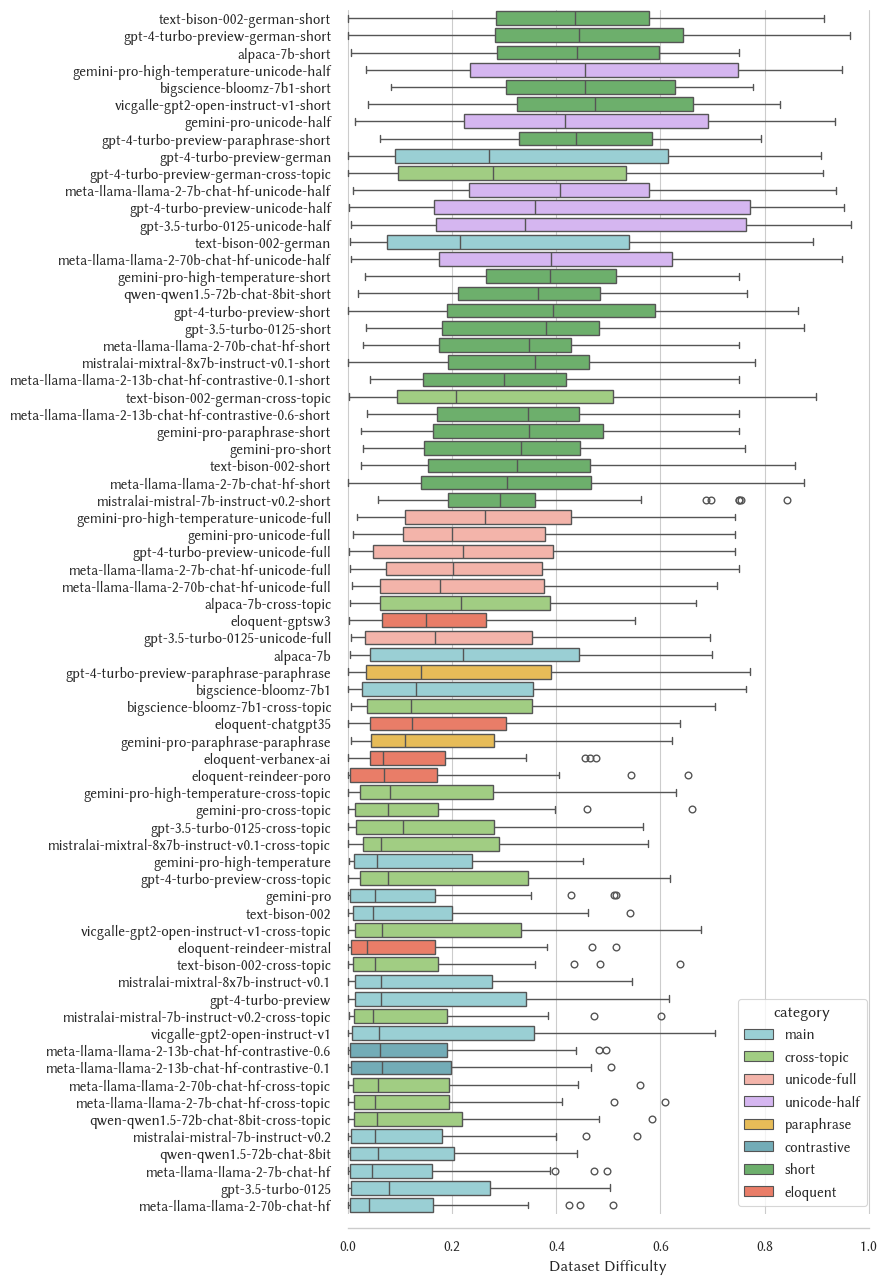

In [20]:
sort_order = df_.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(9, 13))
sns.boxplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(
    xlabel='Dataset Difficulty', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

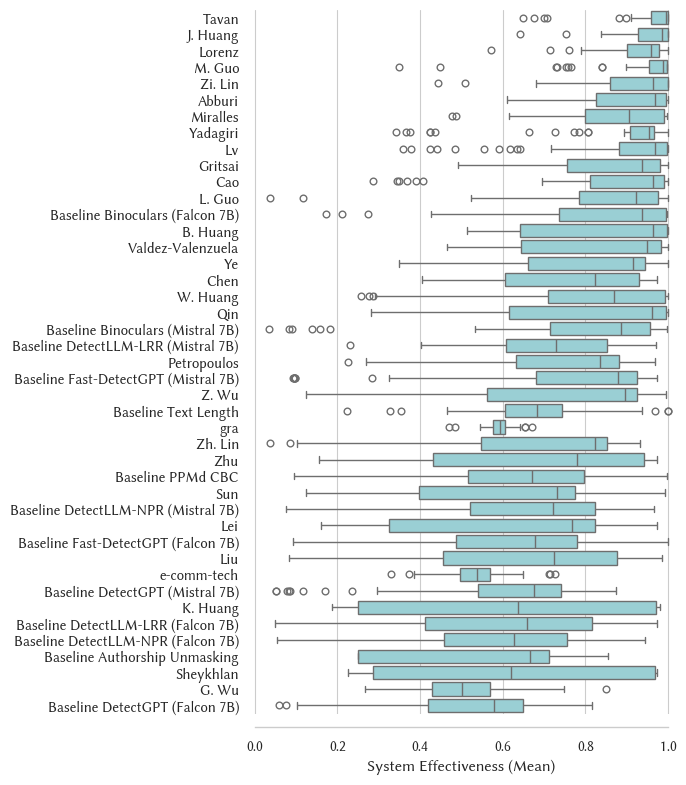

In [21]:
plt.figure(figsize=(7, 8))
sns.boxplot(data=df, y='team', x='mean', order=df_system_mean_adjusted.reset_index()['team']).set(
    xlabel='System Effectiveness (Mean)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [22]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
gemini-pro-high-temperature-unicode-half,0.472674,0.384349,0.503651,0.541930,0.550256,0.490535
vicgalle-gpt2-open-instruct-v1-short,0.410023,0.326023,0.439279,0.589000,0.607349,0.474256
bigscience-bloomz-7b1-short,0.435860,0.354116,0.476558,0.533186,0.523233,0.464581
gemini-pro-unicode-half,0.452070,0.371721,0.485302,0.481093,0.463884,0.450767
gpt-4-turbo-preview-german-short,0.409000,0.343419,0.473814,0.504605,0.483093,0.442791
...,...,...,...,...,...,...
text-bison-002,0.104930,0.109442,0.122209,0.122372,0.112395,0.114279
mistralai-mistral-7b-instruct-v0.2,0.101581,0.108488,0.118930,0.120233,0.117023,0.113209
meta-llama-llama-2-70b-chat-hf,0.095279,0.103023,0.111814,0.122977,0.117884,0.110209


In [23]:
top_idx = df_system_mean_adjusted.iloc[:10].index

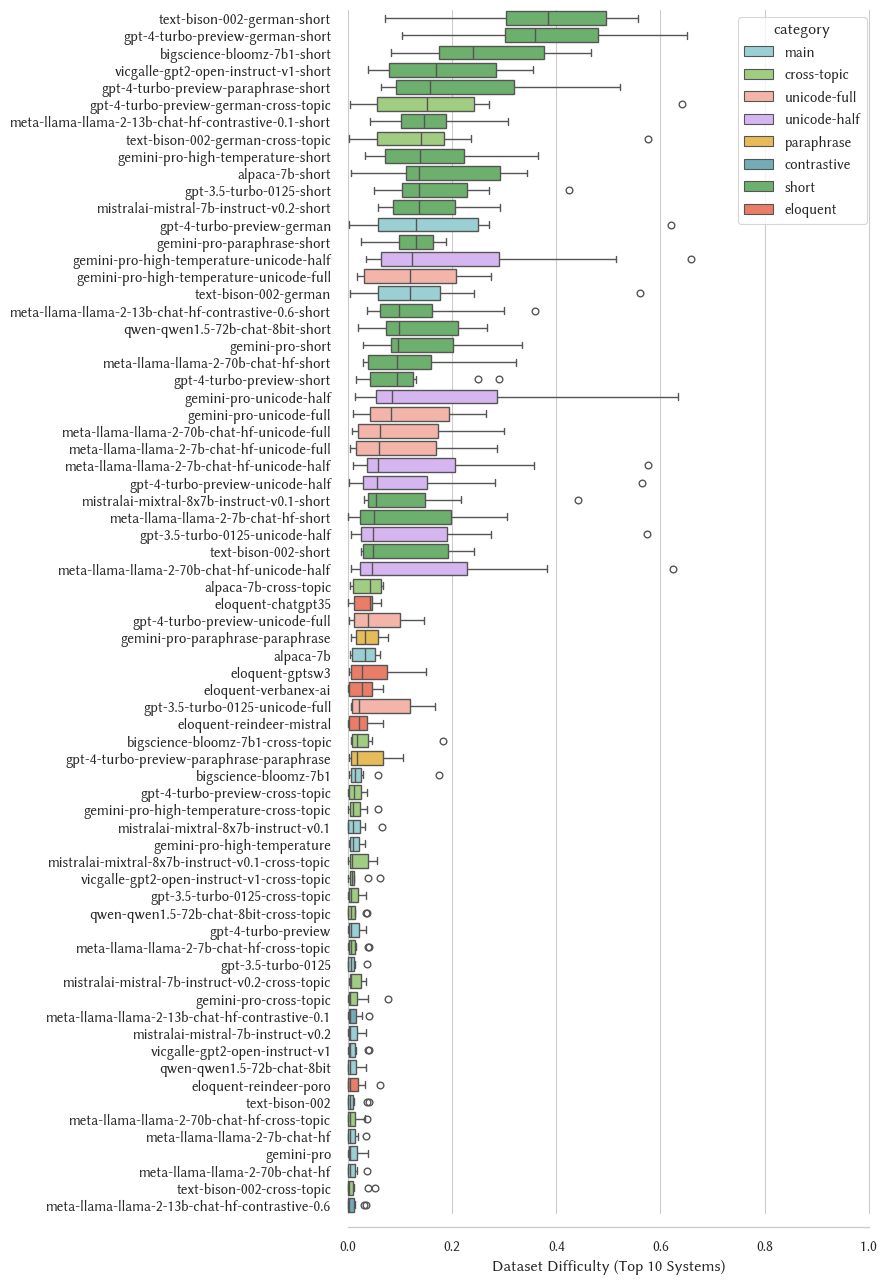

In [24]:
dataset_difficulty_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = dataset_difficulty_top.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(9, 13))
sns.boxplot(data=dataset_difficulty_top, y='dataset', x='mean', hue='category', order=sort_order).set(
    xlabel='Dataset Difficulty (Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-top.pdf')
plt.show()

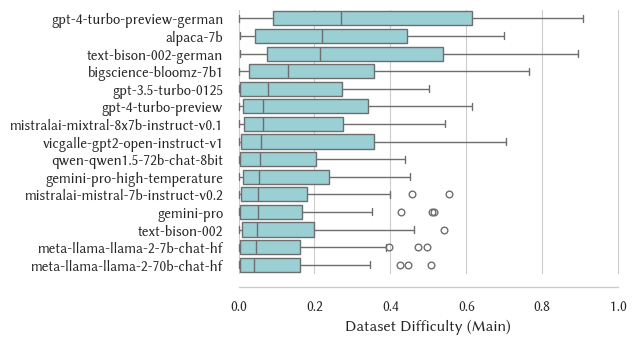

In [25]:
dataset_difficulty_main = (1 - df).query('category == "main"')
sort_order = dataset_difficulty_main.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(6.5, 3.6))
sns.boxplot(data=dataset_difficulty_main, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main.pdf')
plt.show()

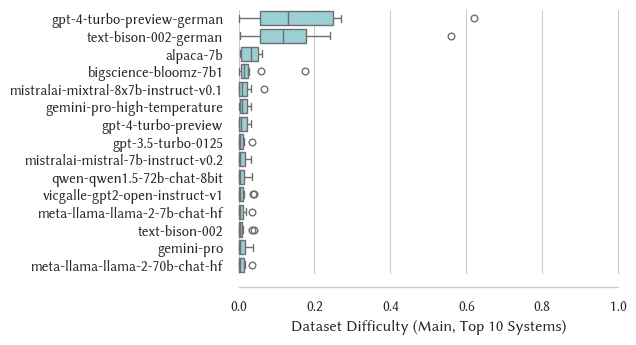

In [26]:
dataset_difficulty_main_top = dataset_difficulty_main.loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = dataset_difficulty_main_top.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(6.5, 3.6))
sns.boxplot(data=dataset_difficulty_main_top, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main, Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main-top.pdf')
plt.show()

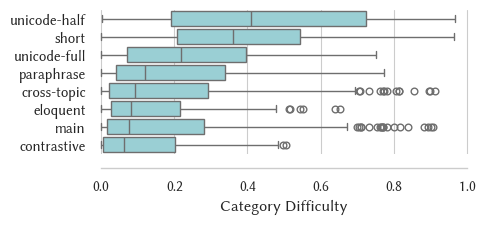

In [27]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(5, 2.4))
sns.boxplot(data=(1 - df), y='category', x='mean', order=sort_order).set(
    xlabel='Category Difficulty', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

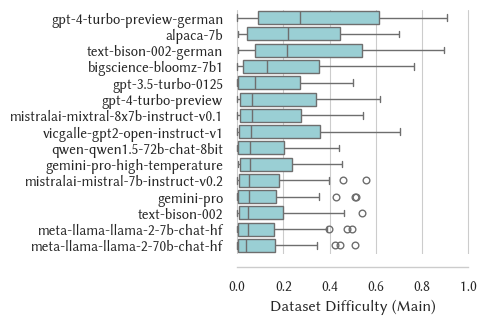

In [28]:
dataset_difficulty_main = (1 - df).query('category == "main"')
sort_order = dataset_difficulty_main.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(5, 3.4))
sns.boxplot(data=dataset_difficulty_main, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main.pdf')
plt.show()

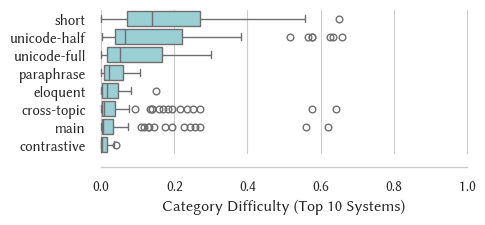

In [29]:
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(5, 2.4))
sns.boxplot(data=df_top, y='category', x='mean', order=sort_order).set(
    xlabel='Category Difficulty (Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

### ELOQUENT Breaker Effectiveness

In [30]:
# df_eloquent_ds = 1 - df.loc[:, :, 'eloquent']
df_eloquent_ds = 1 - df.loc[top_idx.get_level_values(0), top_idx.get_level_values(1), 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

roc-auc  \
team     system             category dataset                              
Lorenz   svm                eloquent eloquent-gptsw3              0.100   
Yadagiri direct-velocity    eloquent eloquent-gptsw3              0.021   
Zi. Lin  blistering-moss    eloquent eloquent-gptsw3              0.086   
Lv       proud-stick        eloquent eloquent-verbanex-ai         0.014   
Yadagiri direct-velocity    eloquent eloquent-reindeer-mistral    0.014   
                                     eloquent-verbanex-ai         0.011   
                                     eloquent-chatgpt35           0.011   
Lv       proud-stick        eloquent eloquent-gptsw3              0.021   
Yadagiri direct-velocity    eloquent eloquent-reindeer-poro       0.007   
Lorenz   svm                eloquent eloquent-chatgpt35           0.029   
                                     eloquent-reindeer-mistral    0.000   
Abburi   muffled-stock      eloquent eloquent-chatgpt35           0.071   
Lorenz   svm                eloquent eloquent-verbanex-ai         0.000   
Miralles corporate-burn     eloquent eloquent-chatgpt35           0.000   
Zi. Lin  blistering-moss    eloquent eloquent-chatgpt35           0.050   
J. Huang charitable-mole_v3 eloquent eloquent-chatgpt35           0.050   
Zi. Lin  blistering-moss    eloquent eloquent-verbanex-ai         0.050   
J. Huang charitable-mole_v3 eloquent eloquent-verbanex-ai         0.050   
Lv       proud-stick        eloquent eloquent-reindeer-mistral    0.007   
Zi. Lin  blistering-moss    eloquent eloquent-reindeer-mistral    0.038   
J. Huang charitable-mole_v3 eloquent eloquent-reindeer-mistral    0.038   
M. Guo   gritty-producer    eloquent eloquent-gptsw3              0.000   
Lv       proud-stick        eloquent eloquent-reindeer-poro       0.003   
Lorenz   svm                eloquent eloquent-reindeer-poro       0.000   
Gritsai  marinated-pantone  eloquent eloquent-gptsw3              0.004   
Lv       proud-stick        eloquent eloquent-chatgpt35           0.000   
M. Guo   gritty-producer    eloquent eloquent-chatgpt35           0.000   
                                     eloquent-verbanex-ai         0.000   
Miralles corporate-burn     eloquent eloquent-gptsw3              0.000   
M. Guo   gritty-producer    eloquent eloquent-reindeer-poro       0.000   
Miralles corporate-burn     eloquent eloquent-verbanex-ai         0.000   
M. Guo   gritty-producer    eloquent eloquent-reindeer-mistral    0.000   
Miralles corporate-burn     eloquent eloquent-reindeer-mistral    0.000   
                                     eloquent-reindeer-poro       0.000   
J. Huang charitable-mole_v3 eloquent eloquent-gptsw3              0.000   
Abburi   muffled-stock      eloquent eloquent-gptsw3              0.000   
Tavan    staff-trunk        eloquent eloquent-reindeer-poro       0.000   
Abburi   muffled-stock      eloquent eloquent-reindeer-poro       0.000   
                                     eloquent-verbanex-ai         0.000   
Tavan    staff-trunk        eloquent eloquent-gptsw3              0.000   
                                     eloquent-verbanex-ai         0.000   
Gritsai  marinated-pantone  eloquent eloquent-chatgpt35           0.000   
                                     eloquent-reindeer-mistral    0.000   
                                     eloquent-reindeer-poro       0.000   
Tavan    staff-trunk        eloquent eloquent-chatgpt35           0.000   
Abburi   muffled-stock      eloquent eloquent-reindeer-mistral    0.000   
Zi. Lin  blistering-moss    eloquent eloquent-reindeer-poro       0.000   
J. Huang charitable-mole_v3 eloquent eloquent-reindeer-poro       0.000   
Tavan    staff-trunk        eloquent eloquent-reindeer-mistral    0.000   
Gritsai  marinated-pantone  eloquent eloquent-verbanex-ai         0.000   

                                                                brier    c@1  \
team     system             category dataset                                   
Lor

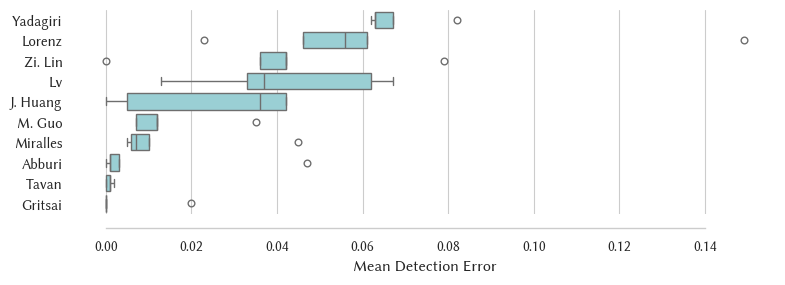

In [31]:
sort_order = df_eloquent_ds.groupby('team').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(8, 3))
sns.boxplot(data=df_eloquent_ds, y='team', x='mean', order=sort_order).set(xlabel='Mean Detection Error', ylabel=None)
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [32]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
eloquent-gptsw3,0.0232,0.0651,0.0387,0.0482,0.0472,0.0446
eloquent-chatgpt35,0.0211,0.0573,0.0238,0.0308,0.0296,0.0325
eloquent-verbanex-ai,0.0125,0.0529,0.0182,0.0323,0.0239,0.0281
eloquent-reindeer-mistral,0.0097,0.0510,0.0170,0.0240,0.0206,0.0245
eloquent-reindeer-poro,0.0010,0.0409,0.0023,0.0134,0.0092,0.0133


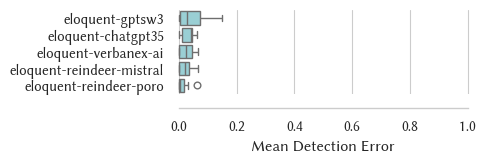

In [33]:
plt.figure(figsize=(5, 1.8))
sns.boxplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(
    xlabel='Mean Detection Error', ylabel=None, xlim=(-0.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()